In [150]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

df1 = pd.read_csv("data/dev101_prepared.csv")
df2 = pd.read_csv("data/dev102_prepared.csv")

In [151]:
df_all = pd.concat([df1, df2], ignore_index=True)

In [152]:
#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum', 'rain_1d_sum', 'rain_7d_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean', 'soil_1d_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean', 'geo_1d_mean',
#    'soil_diff', 'geo_diff', 'soil_1h_std', 'geo_1h_std'
#]

feature_cols = [
    'soil', 'rain', 'temp', 'humi', 'geo',
]

#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean',
#]

In [153]:
missing = [col for col in feature_cols if col not in df_all.columns]
if missing:
    raise ValueError(f"ขาดคอลัมน์ในข้อมูลทั้งหมด: {missing}")

In [154]:
df_train, df_temp = train_test_split(df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.35, random_state=42)

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values
X_test = df_test[feature_cols].values

Train: 131572, Validation: 21381, Test: 11513


In [155]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [156]:
iso_model = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_model.fit(X_train_scaled)

IsolationForest(contamination=0.03, random_state=42)

In [157]:
df_train['anomaly_score'] = iso_model.decision_function(X_train_scaled)
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
df_test['anomaly_score'] = iso_model.decision_function(X_test_scaled)

In [158]:
#crit_thresh = np.percentile(df_train['anomaly_score'], 1)
#warn_thresh = np.percentile(df_train['anomaly_score'], 10)

crit_thresh = -0.1
warn_thresh = 0

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

for df in [df_train, df_val, df_test]:
    df['risk_level'] = df['anomaly_score'].apply(classify_risk)

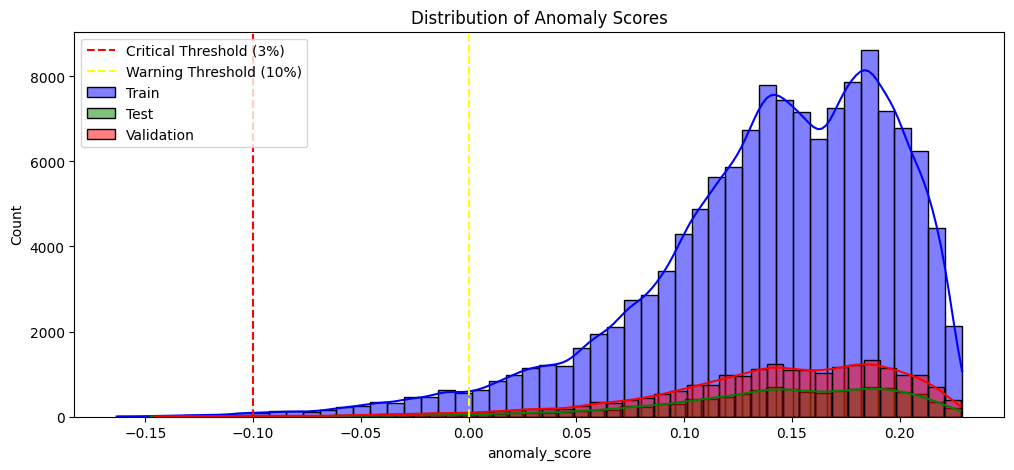

In [159]:

plt.figure(figsize=(12,5))
sns.histplot(df_train['anomaly_score'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(df_test['anomaly_score'], bins=50, kde=True, color='green', label='Test')
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='red', label='Validation')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold (3%)')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold (10%)')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()


In [160]:
print(df_train['risk_level'].value_counts(normalize=True))
print(df_test['risk_level'].value_counts(normalize=True))
print(df_val['risk_level'].value_counts(normalize=True))

risk_level
Normal      0.969994
Warning     0.028099
Critical    0.001908
Name: proportion, dtype: float64
risk_level
Normal      0.970729
Warning     0.027274
Critical    0.001998
Name: proportion, dtype: float64
risk_level
Normal      0.971984
Warning     0.025490
Critical    0.002526
Name: proportion, dtype: float64


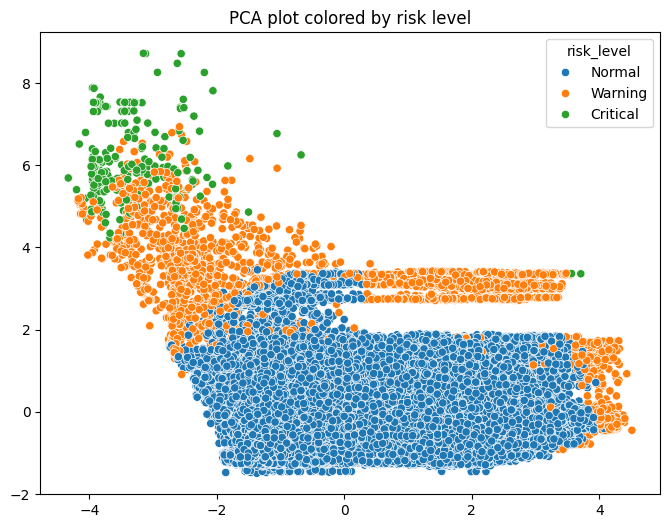

In [161]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_train['risk_level'])
plt.title('PCA plot colored by risk level')
plt.show()


In [162]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
temp  0.674379  0.022140
geo   0.002021  0.854774
rain -0.188843  0.429158
soil -0.246833 -0.290814
humi -0.669791  0.011044


C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\1129453054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all_labeled, x='risk_level', order=['Normal', 'Warning', 'Critical'], palette='Set2')


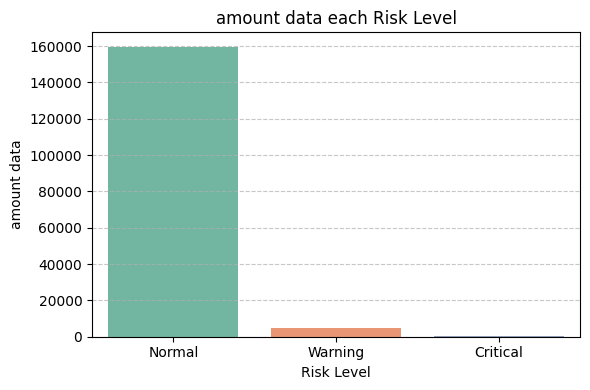

In [163]:
df_all_labeled = pd.concat([df_train, df_val, df_test], ignore_index=True)

plt.figure(figsize=(6, 4))
sns.countplot(data=df_all_labeled, x='risk_level', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [164]:
df_all_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164466 entries, 0 to 164465
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      164466 non-null  object 
 1   devID          164466 non-null  float64
 2   soil           164466 non-null  float64
 3   rain           164466 non-null  float64
 4   temp           164466 non-null  float64
 5   humi           164466 non-null  float64
 6   geo            164466 non-null  float64
 7   unixt          164466 non-null  float64
 8   lat            164466 non-null  float64
 9   lng            164466 non-null  float64
 10  rain_1h_sum    164466 non-null  float64
 11  rain_3h_sum    164466 non-null  float64
 12  rain_6h_sum    164466 non-null  float64
 13  rain_12h_sum   164466 non-null  float64
 14  rain_1d_sum    164466 non-null  float64
 15  rain_7d_sum    164466 non-null  float64
 16  soil_1h_mean   164466 non-null  float64
 17  soil_3h_mean   164466 non-nul

C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\2034111960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


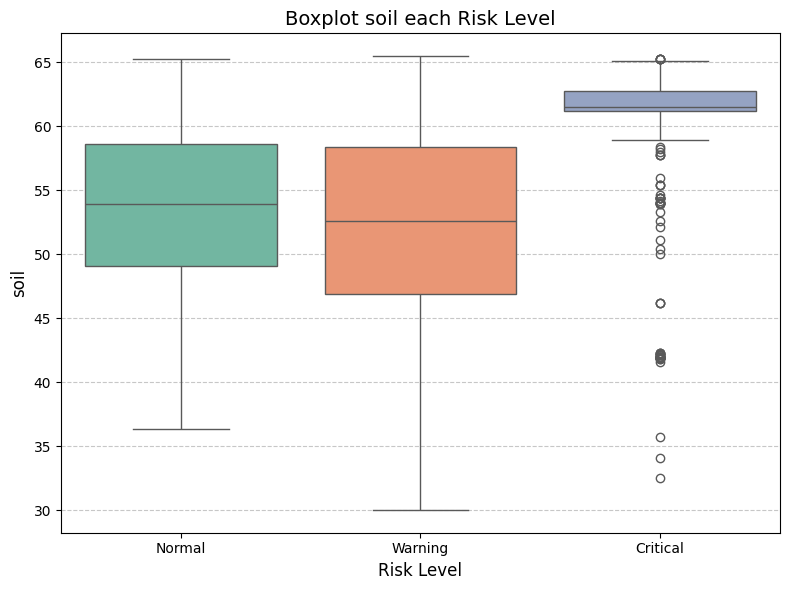

C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\2034111960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


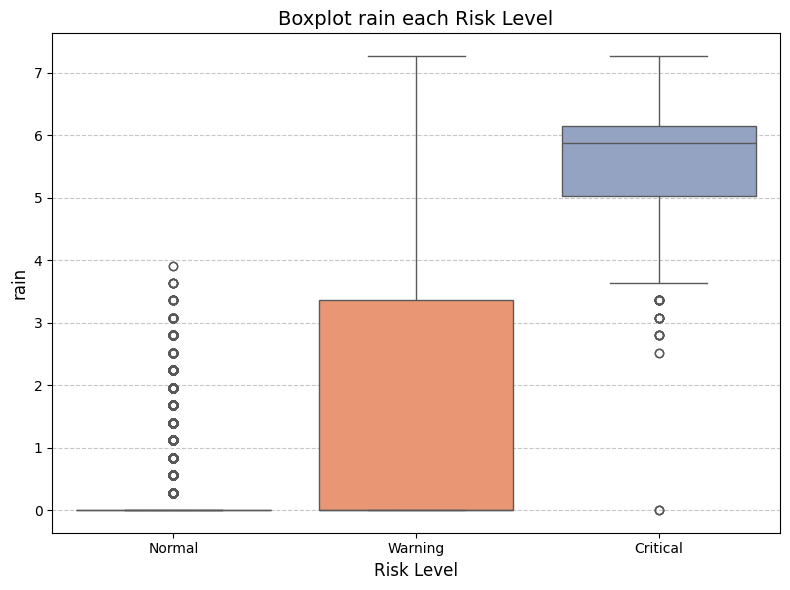

C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\2034111960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


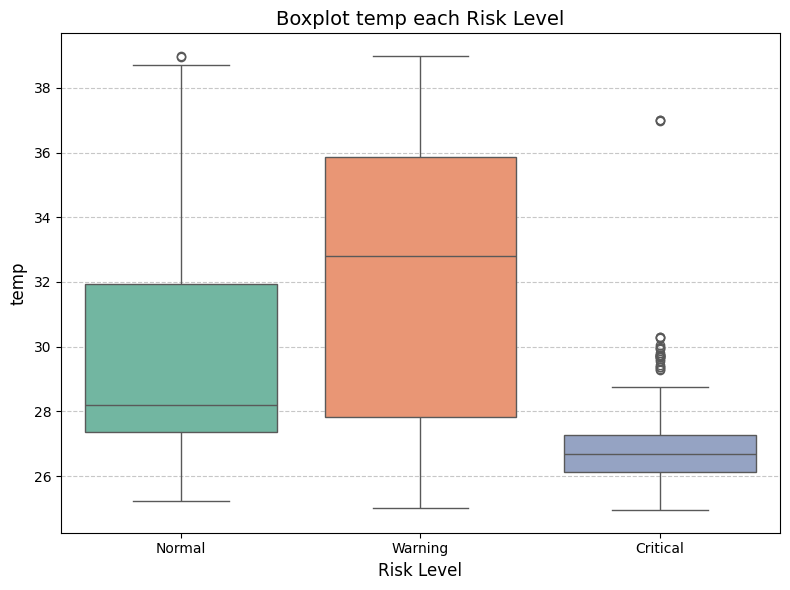

C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\2034111960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


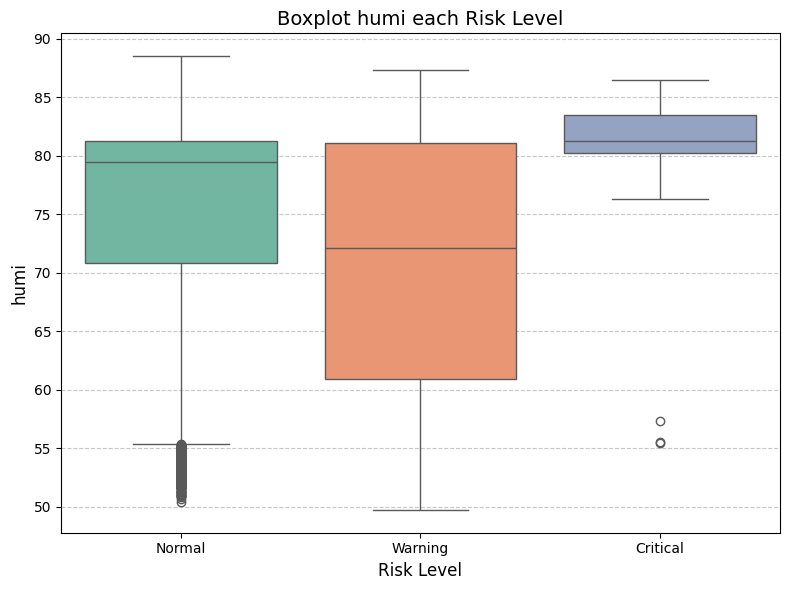

C:\Users\ahmad\AppData\Local\Temp\ipykernel_364\2034111960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


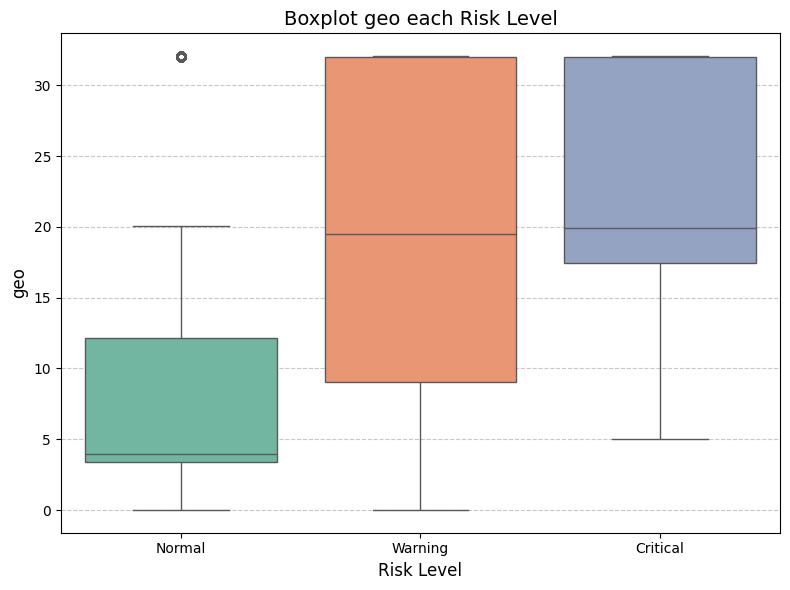

Create Box Plot for every Feature successfully!


In [165]:
features = ['soil', 'rain', 'temp', 'humi', 'geo',]
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


    plt.title(f'Boxplot {feature} each Risk Level', fontsize=14)
    plt.xlabel('Risk Level', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Create Box Plot for every Feature successfully!")